# HIP RDataFrame Demonstration 1: Basic operations

In this demonstration we will go through:
1. How to load an RDF
2. How to filter columns in an RDF
3. How to create custom columns and redefine columns
4. How to create basic ROOT histograms such as TH1D, TH2D and TProfile

The [RDF class reference](https://root.cern/doc/master/classROOT_1_1RDataFrame.html) is always quite useful when using RDFs. You will find most of the information presented here in the class reference, likely with more detail and possibilities.

-- Made by Nico Toikka

## Initialization

Import the only library you'll ever need.

In [1]:
import ROOT

Welcome to JupyROOT 6.30/04


ROOT and RDFs can automatically use multithreading. You can set it up with the following command, and if no number is specified ROOT will default to all threads that are available to it, so be careful!

In [2]:
ROOT.EnableImplicitMT(4) # MT for multithreading

## Loading a NanoAOD

To load a NanoAOD to an RDF you need to know the file location and the tree you want to access. RDF supports XrootD, which means that you can use the cms and eos directors if you want to access files not currently on your own machine. For using multiple files you can chain them with TChain and pass the TChain to the RDF constructor (see the 4th RDF demonstration).

Advanced initializations include the possibility to use a TChain, a distributed RDF to use Dask or Spark for processing, and a definition from a specifications JSON that allows to use per sample definitions. These are not covered in this demonstration.

In [3]:
file = "/eos/cms/store/data/Run2024E/JetMET0/NANOAOD/PromptBTVJMENano_v2-v1/70000/85519923-c3a9-44bf-b366-7d2a4aea4a5d.root"
tree = "Events"
df = ROOT.RDataFrame(tree, file)

With the RDF loaded you can have an overview of the contents using `.Describe()`. You can also show some individual column values with `.Display()`, but this isn't available when using multithreading.

In [4]:
df.Describe().Print()

Dataframe from TChain Events in file /eos/cms/store/data/Run2024E/JetMET0/NANOAOD/PromptBTVJMENano_v2-v1/70000/85519923-c3a9-44bf-b366-7d2a4aea4a5d.root

Property                Value
--------                -----
Columns in total         2521
Columns from defines        0
Event loops run             0
Processing slots            4

Column                                                                                  Type                            Origin
------                                                                                  ----                            ------
BeamSpot_sigmaZ                                                                         Float_t                         Dataset
BeamSpot_sigmaZError                                                                    Float_t                         Dataset
BeamSpot_type                                                                           Short_t                         Dataset
BeamSpot_z                 

Warning in <TClass::Init>: no dictionary for class edm::Hash<1> is available
Warning in <TClass::Init>: no dictionary for class edm::ParameterSetBlob is available
Warning in <TClass::Init>: no dictionary for class edm::ProcessHistory is available
Warning in <TClass::Init>: no dictionary for class edm::ProcessConfiguration is available
Warning in <TClass::Init>: no dictionary for class pair<edm::Hash<1>,edm::ParameterSetBlob> is available


## Filtering

To filter events can be quite simple. The `.Filter()` can be used along with conditions to drop events that don't pass the condition. Here's a rough dijet cut that will be implemented:
- require at least two jets
- one in barrel ($|\eta | < 1.3$)
- if there's a third jet it should have pt less than 0.2 of the average of the dijet systems pt.

Notice that everything that happens when filtering RDF columns is in C++. From the following cell you should pick up that

- It's quite convenient to use Python's f-string syntax to place variable values in to the RDF filters
- You can label filters with a second string in the `.Filter()` call. This will be useful when monitoring the operations.
- Filters follow C++ syntax, so you should familiarize yourself with it and common operations such as OR=`||`, AND=`&&`, and the tertiary operator `if ? then : else`
- Also related to C++, there's a hidden `using namespace std` in the RDF calls. In the $\eta$-cut you can notice `abs()` being used.

In [5]:
alpha = 0.2
eta_cut = 1.3

df = (df.Filter("nJet >= 2", "Require at least 2 jets")
      .Filter(f"abs(Jet_eta[0]) < {eta_cut} || abs(Jet_eta[1]) < {eta_cut}", f"Require one of the leading jets in the abs(eta) < {eta_cut} region")
      .Filter(f"nJet > 2 ? Jet_pt[2] / (0.5 * (Jet_pt[0] + Jet_pt[1])) < {alpha} : true", f"Third jets pt should be less than {alpha} of the dijet average pt")
)

You can monitor the effects of your filters with `.Report`, but you shouldn't use this like presented here between every filter! RDF benefits of what's called _lazy evalution_: filters and other actions are only run when they are needed. `.Report().Print()` triggers the evaluation, which means that you're possibly wasting parallelization by calling it. Only calling `.Report()` is won't trigger the evaluation, but without the `.Print()` you won't be able to see the results of the report. 

Let's see how many events were cut and by which filters.

In [6]:
df.Report().Print()

Require at least 2 jets: pass=485504     all=485980     -- eff=99.90 % cumulative eff=99.90 %
Require one of the leading jets in the abs(eta) < 1.3 region: pass=328112     all=485504     -- eff=67.58 % cumulative eff=67.52 %
Third jets pt should be less than 0.2 of the dijet average pt: pass=83117      all=328112     -- eff=25.33 % cumulative eff=17.10 %


## Defining and redefining columns

To derive columns either from functions or columns that are already in the NanoAOD file you can use the `.Define()` method. These columns, and the ones already defined, can later be modified with the `.Redefine()` method. As with filters, C++ syntax is required and you can use stl and ROOT functions as your assistance.

Let's have a look at the dijet systems invariant mass. This is a variable that's not defined natively in a NanoAOD, so we will have to define it ourselves. To make things easy we can use ROOTs LorentzVector datatype to define the four vectors of the two jets and then sum them to a new column. Columns are defined with `.Define(columnName, columnDefinition)`, now there's no label as with filters.

For reasons we will see later, let's also define a weight column that can just be 1.0 for all the events and an asymmetry column to compare the two jets.

In [7]:
df = (df.Define("Jet_leadVector", "ROOT::Math::PtEtaPhiMVector(Jet_pt[0], Jet_eta[0], Jet_phi[0], Jet_mass[0])")
      .Define("Jet_trailVector", "ROOT::Math::PtEtaPhiMVector(Jet_pt[1], Jet_eta[1], Jet_phi[1], Jet_mass[1])")
      .Define("Dijet_fourVector", "Jet_leadVector + Jet_trailVector")
      .Define("Dijet_invMass", "Dijet_fourVector.M()")
      .Define("Dijet_asymmetry", "abs(Jet_pt[0] - Jet_pt[1]) / (Jet_pt[0] + Jet_pt[1])") # Due to not selecting the order of the jets randomly, there will be an upwards bias in the asymmetry
      .Define("Jet_leadPt", "Jet_pt[0]") # If you know that you will be using a variable for binning, you need to define it as a column!
      .Define("weight", "1.0")
     )

Just for the sake of it, let's redefine our standard jet columns to only include the dijet system. You should be **extremely careful** when redefining columns, since it can mess with vector lengths, indices, and it can be difficult to debug. To keep things clear we'll redefine the columns to a new RDF (technically an RNode), and we can compare the effect of the redefinition in later plots.

In [8]:
df_redefined = (df.Redefine("Jet_pt", "ROOT::VecOps::Take(Jet_pt, 2)")
      .Redefine("Jet_eta", "ROOT::VecOps::Take(Jet_eta, 2)")
      .Redefine("Jet_phi", "ROOT::VecOps::Take(Jet_phi, 2)")
      .Redefine("Jet_mass", "ROOT::VecOps::Take(Jet_mass, 2)")
     )

Let's have a look at the status of the RDF after all these changes.

In [9]:
df.Describe().Print()

Dataframe from TChain Events in file /eos/cms/store/data/Run2024E/JetMET0/NANOAOD/PromptBTVJMENano_v2-v1/70000/85519923-c3a9-44bf-b366-7d2a4aea4a5d.root

Property                Value
--------                -----
Columns in total         2528
Columns from defines        7
Event loops run             1
Processing slots            4

Column                                                                                  Type                                                            Origin
------                                                                                  ----                                                            ------
BeamSpot_sigmaZ                                                                         Float_t                                                         Dataset
BeamSpot_sigmaZError                                                                    Float_t                                                         Dataset
BeamSpot_type              

## Histograms

Lastly, we can define histograms from the RDF columns. Let's start off by drawing the pts of the jets in both RDFs.

### 1D histograms

In [10]:
jet_pts = df.Histo1D(("Jet_pts", "Jet_pts;p_{t} (GeV);Count", 100, 200, 3000), "Jet_pt", "weight")
jet_pts_redefined = df_redefined.Histo1D(("Dijet_pts", "Dijet_pts", 100, 200, 3000), "Jet_pt", "weight")

As with `.Report()`, these `jet_pts` and `jet_pts_redefined` aren't actually histogram objects! They are waiting for an evaluation, which can be triggered by calling `.Draw()` on them, or if you want the `TH1D` object `.GetValue()`.

**Note:**
There's a (annoying) technical subtlety to this: triggering the evaluation for any object will trigger it for all the objects defined in RDFs in the program. This is nice for parallelization, as the computation will be more spread out, but as with report you should wait until drawing things and calling the evaluation.


Back to the example. With the histograms defined we can trigger the evaluation and draw them with standard ROOT syntax to a TCanvas. Let's first draw the original jet pts.

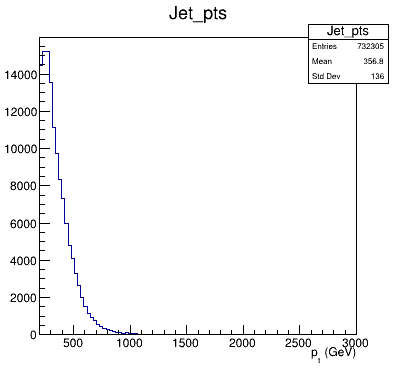

In [11]:
canvas = ROOT.TCanvas("canv", "canv", 400, 400)
jet_pts.Draw()
canvas.Draw()

Then, let's get the histogram of the redefined values and draw that. Since we're in a Jupyter notebook, we can interactively inspect the histogram using cell magic %jsroot on.

In [12]:
%jsroot on
jet_pts_redefined.Draw()
canvas.Draw()

Couple of comments:
1. It might be a bit difficult to see from here, but there are less events in low pts for the second one. We will have a look at that bit later.
2. Notice how there's an x-axis label in the first histogram. This can be added when defining the histogram in the second string. You'll notice that the `jet_pts` histogram title definition has the format "title;x-label;y-label", and in it you can also use LaTeX syntax, as was done with the pt.
3. You can play around with the drawing in JSROOT in quite many ways, such as changing the color of the histograms, zooming in and out, setting log axes, and saving the current view by clicking. You'll have to left click on different objects in the canvas to find all the possibilities, and there's also a menu button in the lower left.

Since we now have the histograms, we can play with them in ROOT. Let's take a difference between the two to only look at the low pts.

It's often safer to explicitly call `.GetValue()` for histograms produced by RDF before using them in histogram computations, so let's start with that and continue with the difference.

In [13]:
jet_pts = jet_pts.GetValue()
jet_pts_redefined = jet_pts_redefined.GetValue()

In [14]:
low_pts = jet_pts - jet_pts_redefined
low_pts.Draw()
canvas.Draw()

Let's finish this section with the dijet invariant mass plot, but this time with a custom binning. You can use for example Numpy arrays to assist with the histogram definition.

In [15]:
import numpy as np
bins = np.geomspace(500, 6800, 200, dtype=float)

In [16]:
dijet_invMass = df.Histo1D(("Dijet_invMass", "Dijet invariant mass;M_{dijet};N", len(bins) - 1, bins), "Dijet_invMass", "weight")
dijet_invMass.Draw()
canvas.Draw()

### 2D histograms and profiles

2D histograms and profiles follow the same syntax and conventions as 1D. Here are some examples of the two.

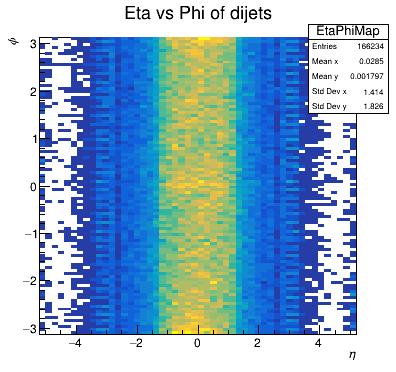

In [17]:
%jsroot off
# ^ seems that JSROOT has some issue with 2D histograms, so this is how to turn it off
eta_phi_map = df_redefined.Histo2D(("EtaPhiMap", "Eta vs Phi of dijets;\eta;\phi", 50, -5.2, 5.2, 100, -np.pi, np.pi), "Jet_eta", "Jet_phi", "weight")
eta_phi_map.Draw()
canvas.Draw()

In [18]:
%jsroot on
asymmetry = df.Profile1D(("Asymmetry", "Asymmetry of the dijet system;p_{t, lead};A", len(bins)-1, bins), "Jet_leadPt", "Dijet_asymmetry", "weight")
asymmetry.Draw()
canvas.Draw()